22
50

In [499]:
layer = 32
filter = 180

In [500]:
sz = 408

In [501]:
%matplotlib inline

In [502]:
from fastai.conv_learner import *
from scipy import ndimage

In [503]:
torch.backends.cudnn.benchmark = True

In [504]:
model = vgg16(pre=True).cuda().eval()
#torchvision.models.vgg16(pretrained=True).cuda().eval()

In [505]:
train_tfms, val_tfms = tfms_from_model(vgg16, sz)

In [506]:
set_trainable(model, False)

In [507]:
class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [508]:
def get_start():
    start_img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255
    start_img = scipy.ndimage.filters.median_filter(start_img, [15, 15, 1])
    start_img_var = V(val_tfms(start_img)[None], requires_grad=True)
    return start_img_var

In [509]:
start_img_var = get_start()

In [510]:
optimizer = torch.optim.Adam([start_img_var], lr=0.1, weight_decay=1e-6)

In [511]:
feat = SaveFeatures(list(model.children())[layer])

In [512]:
def content_loss2(x):
    model(x)  
    output = feat.features
    return -output[0,filter].mean()

In [513]:
def step(loss_func):
    global n_iter
    optimizer.zero_grad()
    loss = loss_func(start_img_var)
    loss.backward()
#    start_img_var.grad.data /= start_img_var.grad.data.norm(2).item() + 1e-5
    n_iter += 1
    if n_iter % 10 == 0: print(f'Iteration: {n_iter}, loss {loss.data[0]}')
    return loss

In [514]:
n_iter = 0
while n_iter < 50:
    optimizer.step(partial(step, content_loss2))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 10, loss -0.8486190438270569
Iteration: 20, loss -1.3023837804794312
Iteration: 30, loss -1.5913301706314087
Iteration: 40, loss -1.8085572719573975
Iteration: 50, loss -1.9798651933670044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


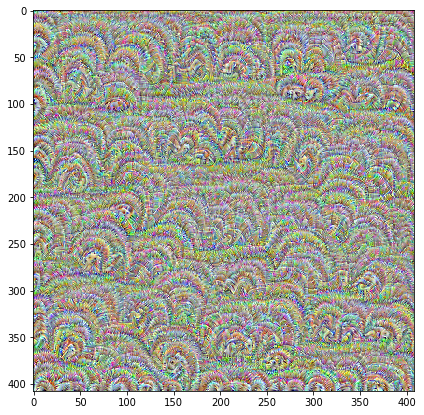

In [515]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))